### mdai python API Hello World

In [1]:
import os
import sys
import random
import math
import numpy as np
import pandas as pd 
import cv2
import matplotlib.pyplot as plt

# import io
# import hashlib 
# import json
# import pydicom

In [2]:
#####################################################
### Hack to use mdai client library!! 
import os 
import sys
MODULE_DIR = os.path.abspath('../../mdai-client-py')
print(MODULE_DIR)
sys.path.append(MODULE_DIR) # go to parent dir
#####################################################

/home/txia/mdai-proj/mdai-client-py


### Import mdai python library modules

In [3]:
from mdai import visualize as vis 
from mdai import preprocess as pps
from mdai import utils 
from mdai import export 

Using TensorFlow backend.


### Define file paths of images and corresponding annotations

In [4]:
# file paths 
data_fp = '../data/hello-world/mdai_public_project_PVq9raBJ_dataset_all_labelgroup_all_2018-07-17-101553.json'
image_fp = '../data/hello-world/mdai_public_project_PVq9raBJ_dataset_all_2018-07-17-101532'

# create a project 
p = pps.Project(data_fp, image_fp)

# show label groups
label_groups = p.get_label_groups()
print('All Label Groups: ')
for label_group in label_groups: 
    print('Name: %s, Id: %s' % (label_group.name, label_group.id))
print('')
    
# show relevant labels for training 
label_group = p.get_label_group_by_id('G_3lv')
labels = label_group.get_labels()
label_ids = [label[0] for label in labels]
print(labels)

All Label Groups: 
Name: Default group, Id: G_3lv

[('L_yxv', 'Abdomen'), ('L_dyy', 'Chest')]


### Show available datasets (for machine learning training)

In [5]:
datasets = p.get_datasets()
for dataset in datasets: 
    print(dataset.name)

TRAIN
VAL
TEST


### Create the "Training" dataset

In [6]:
# create training dataset 
train_dataset = p.get_dataset_by_name('TRAIN')
train_ann = train_dataset.get_annotations()
train_imgs_anns = train_dataset.associate_images_and_annotations(train_ann, label_ids=label_ids)
train_image_ids = train_dataset.get_image_ids(train_ann)

# show as a pandas dataframe 
train_ann_df = pd.DataFrame(train_ann); train_ann_df

,SOPInstanceUID,SeriesInstanceUID,StudyInstanceUID,annotationNumber,createdAt,createdById,data,height,id,labelId,machineLearningModelId,note,radlexTagIds,reviewsNegativeCount,reviewsPositiveCount,updatedAt,updatedById,width
0,1.2.276.0.7230010.3.1.4.8323329.15725.15317874...,1.2.276.0.7230010.3.1.3.8323329.15725.15317874...,1.2.276.0.7230010.3.1.2.8323329.15725.15317874...,None,2018-07-17T13:57:17.820Z,U_mom,None,None,A_8rm6gk,L_yxv,None,None,[],0,0,2018-07-17T13:57:17.827Z,U_mom,None
1,1.2.276.0.7230010.3.1.4.8323329.15757.15317874...,1.2.276.0.7230010.3.1.3.8323329.15757.15317874...,1.2.276.0.7230010.3.1.2.8323329.15757.15317874...,None,2018-07-17T13:57:25.409Z,U_mom,None,None,A_d3g9rv,L_yxv,None,None,[],0,0,2018-07-17T13:57:25.415Z,U_mom,None
2,1.2.276.0.7230010.3.1.4.8323329.16092.15317874...,1.2.276.0.7230010.3.1.3.8323329.16092.15317874...,1.2.276.0.7230010.3.1.2.8323329.16092.15317874...,None,2018-07-17T13:57:22.545Z,U_mom,None,None,A_277g0w,L_dyy,None,None,[],0,0,2018-07-17T13:57:22.550Z,U_mom,None
3,1.2.276.0.7230010.3.1.4.8323329.16110.15317874...,1.2.276.0.7230010.3.1.3.8323329.16110.15317874...,1.2.276.0.7230010.3.1.2.8323329.16110.15317874...,None,2018-07-17T13:58:07.424Z,U_mom,None,None,A_277g60,L_dyy,None,None,[],0,0,2018-07-17T13:58:07.429Z,U_mom,None
4,1.2.276.0.7230010.3.1.4.8323329.15727.15317874...,1.2.276.0.7230010.3.1.3.8323329.15727.15317874...,1.2.276.0.7230010.3.1.2.8323329.15727.15317874...,None,2018-07-17T13:58:30.921Z,U_mom,None,None,A_2qn4v4,L_yxv,None,None,[],0,0,2018-07-17T13:58:30.928Z,U_mom,None
5,1.2.276.0.7230010.3.1.4.8323329.16035.15317874...,1.2.276.0.7230010.3.1.3.8323329.16035.15317874...,1.2.276.0.7230010.3.1.2.8323329.16035.15317874...,None,2018-07-17T13:59:17.124Z,U_mom,None,None,A_85n0zq,L_dyy,None,None,[],0,0,2018-07-17T13:59:17.131Z,U_mom,None
6,1.2.276.0.7230010.3.1.4.8323329.15697.15317874...,1.2.276.0.7230010.3.1.3.8323329.15697.15317874...,1.2.276.0.7230010.3.1.2.8323329.15697.15317874...,None,2018-07-17T13:59:41.033Z,U_mom,None,None,A_2og3xe,L_yxv,None,None,[],0,0,2018-07-17T13:59:41.039Z,U_mom,None
7,1.2.276.0.7230010.3.1.4.8323329.15822.15317874...,1.2.276.0.7230010.3.1.3.8323329.15822.15317874...,1.2.276.0.7230010.3.1.2.8323329.15822.15317874...,None,2018-07-17T13:59:42.368Z,U_mom,None,None,A_2ejx40,L_yxv,None,None,[],0,0,2018-07-17T13:59:42.373Z,U_mom,None
8,1.2.276.0.7230010.3.1.4.8323329.15735.15317874...,1.2.276.0.7230010.3.1.3.8323329.15735.15317874...,1.2.276.0.7230010.3.1.2.8323329.15735.15317874...,None,2018-07-17T13:55:27.037Z,U_mom,None,None,A_2w5461,L_dyy,None,None,[],0,0,2018-07-17T13:55:27.042Z,U_mom,None
9,1.2.276.0.7230010.3.1.4.8323329.16090.15317874...,1.2.276.0.7230010.3.1.3.8323329.16090.15317874...,1.2.276.0.7230010.3.1.2.8323329.16090.15317874...,None,2018-07-17T13:55:29.355Z,U_mom,None,None,A_2931p7,L_dyy,None,None,[],0,0,2018-07-17T13:55:29.362Z,U_mom,None


### Create the "Validation" dataset

In [7]:
val_dataset = p.get_dataset_by_name('VAL')
val_ann = val_dataset.get_annotations()
val_imgs_anns = train_dataset.associate_images_and_annotations(val_ann, label_ids)
val_image_ids = val_dataset.get_image_ids(val_ann)

# show as a pandas dataframe 
val_ann_df = pd.DataFrame(val_ann); val_ann_df

,SOPInstanceUID,SeriesInstanceUID,StudyInstanceUID,annotationNumber,createdAt,createdById,data,height,id,labelId,machineLearningModelId,note,radlexTagIds,reviewsNegativeCount,reviewsPositiveCount,updatedAt,updatedById,width
0,1.2.276.0.7230010.3.1.4.8323329.15583.15317874...,1.2.276.0.7230010.3.1.3.8323329.15583.15317874...,1.2.276.0.7230010.3.1.2.8323329.15583.15317874...,None,2018-07-17T14:03:43.274Z,U_mom,None,None,A_2vp3xm,L_dyy,None,None,[],0,0,2018-07-17T14:03:43.280Z,U_mom,None
1,1.2.276.0.7230010.3.1.4.8323329.15505.15317874...,1.2.276.0.7230010.3.1.3.8323329.15505.15317874...,1.2.276.0.7230010.3.1.2.8323329.15505.15317874...,None,2018-07-17T14:03:36.134Z,U_mom,None,None,A_277g50,L_yxv,None,None,[],0,0,2018-07-17T14:03:36.142Z,U_mom,None
2,1.2.276.0.7230010.3.1.4.8323329.15506.15317874...,1.2.276.0.7230010.3.1.3.8323329.15506.15317874...,1.2.276.0.7230010.3.1.2.8323329.15506.15317874...,None,2018-07-17T14:03:32.229Z,U_mom,None,None,A_8nyqom,L_dyy,None,None,[],0,0,2018-07-17T14:03:32.235Z,U_mom,None
3,1.2.276.0.7230010.3.1.4.8323329.15586.15317874...,1.2.276.0.7230010.3.1.3.8323329.15586.15317874...,1.2.276.0.7230010.3.1.2.8323329.15586.15317874...,None,2018-07-17T14:03:34.622Z,U_mom,None,None,A_8m6jv6,L_dyy,None,None,[],0,0,2018-07-17T14:03:34.629Z,U_mom,None
4,1.2.276.0.7230010.3.1.4.8323329.15508.15317874...,1.2.276.0.7230010.3.1.3.8323329.15508.15317874...,1.2.276.0.7230010.3.1.2.8323329.15508.15317874...,None,2018-07-17T14:03:41.653Z,U_mom,None,None,A_d3g9ey,L_yxv,None,None,[],0,0,2018-07-17T14:03:41.660Z,U_mom,None
5,1.2.276.0.7230010.3.1.4.8323329.15509.15317874...,1.2.276.0.7230010.3.1.3.8323329.15509.15317874...,1.2.276.0.7230010.3.1.2.8323329.15509.15317874...,None,2018-07-17T14:03:37.860Z,U_mom,None,None,A_20153o,L_dyy,None,None,[],0,0,2018-07-17T14:03:37.867Z,U_mom,None
6,1.2.276.0.7230010.3.1.4.8323329.15512.15317874...,1.2.276.0.7230010.3.1.3.8323329.15512.15317874...,1.2.276.0.7230010.3.1.2.8323329.15512.15317874...,None,2018-07-17T14:03:51.350Z,U_mom,None,None,A_2og3ee,L_yxv,None,None,[],0,0,2018-07-17T14:03:51.357Z,U_mom,None
7,1.2.276.0.7230010.3.1.4.8323329.15507.15317874...,1.2.276.0.7230010.3.1.3.8323329.15507.15317874...,1.2.276.0.7230010.3.1.2.8323329.15507.15317874...,None,2018-07-17T14:03:59.564Z,U_mom,None,None,A_2ejxy0,L_dyy,None,None,[],0,0,2018-07-17T14:03:59.571Z,U_mom,None
8,1.2.276.0.7230010.3.1.4.8323329.15510.15317874...,1.2.276.0.7230010.3.1.3.8323329.15510.15317874...,1.2.276.0.7230010.3.1.2.8323329.15510.15317874...,None,2018-07-17T14:07:03.576Z,U_mom,None,None,A_2kx4l6,L_yxv,None,None,[],0,0,2018-07-17T14:07:03.581Z,U_mom,None
9,1.2.276.0.7230010.3.1.4.8323329.15511.15317874...,1.2.276.0.7230010.3.1.3.8323329.15511.15317874...,1.2.276.0.7230010.3.1.2.8323329.15511.15317874...,None,2018-07-17T14:07:14.582Z,U_mom,None,None,A_81qkx4,L_yxv,None,None,[],0,0,2018-07-17T14:07:14.588Z,U_mom,None


### Display a few images

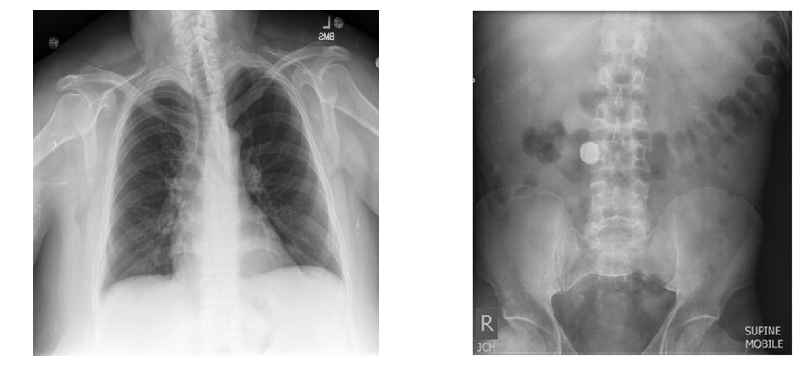

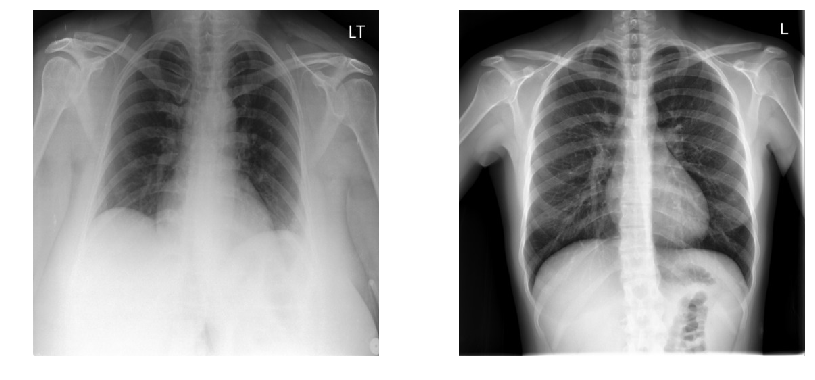

In [8]:
# visualize a few train images 
vis.display_images(train_image_ids[:2], cols=2)
vis.display_images(val_image_ids[:2], cols=2)

### Use Keras ML library for training and validation

In [9]:
from keras import applications
#from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [10]:
# label_ids to class_ids 
# [('L_yxv', 'Abdomen'), ('L_dyy', 'Chest')]
def label_id_to_class_id(label_id): 
    if label_id == 'L_yxv': 
        return 0 
    else: 
        return 1 

def class_id_to_label(class_id):
    if class_id == 0: 
        return 'Abdomen'
    elif class_id == 1: 
        return 'Chest'
    else: 
        return 'None'

In [11]:
# Define model parameters 
img_width = 256
img_height = 256
epoch = 5

params = {'dim': (img_width,img_height),
          'batch_size': 5,
          'n_classes': 2,
          'n_channels': 3,
          'shuffle': True, 
          'label_id_to_class_id': label_id_to_class_id,
         }

In [12]:
# Transfer Learning 
# Use the InceptionV3 pre-trained model as base model 
base_model = applications.InceptionV3(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))
model_top  = Sequential()
model_top.add(GlobalAveragePooling2D(input_shape=base_model.output_shape[1:], data_format=None)),  
model_top.add(Dense(256, activation='relu'))
model_top.add(Dropout(0.5))
model_top.add(Dense(2, activation='softmax')) 

model = Model(inputs=base_model.input, outputs=model_top(base_model.output))

model.compile(optimizer=Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08,decay=0.0), 
              loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
import warnings
warnings.filterwarnings('ignore')

train_generator = utils.DataGenerator(train_image_ids, train_imgs_anns, **params)
val_generator = utils.DataGenerator(val_image_ids, val_imgs_anns, **params)

# Set callback functions to early stop training and save the best model so far
callbacks = [EarlyStopping(monitor='val_loss', patience=5),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', 
                             save_best_only=True)]

history = model.fit_generator(
            generator=train_generator,
            epochs=epoch,
            callbacks=callbacks,
            verbose=1,            
            validation_data=val_generator,
            use_multiprocessing=True, 
            workers=6)         

Epoch 1/5
13/13 [==============================] - 40s 3s/step - loss: 0.5595 - acc: 0.7231 - val_loss: 0.2152 - val_acc: 1.0000
Epoch 2/5
13/13 [==============================] - 30s 2s/step - loss: 0.1464 - acc: 0.9385 - val_loss: 0.0840 - val_acc: 1.0000
Epoch 3/5
13/13 [==============================] - 28s 2s/step - loss: 0.1206 - acc: 0.9692 - val_loss: 0.0384 - val_acc: 1.0000
Epoch 4/5
13/13 [==============================] - 29s 2s/step - loss: 0.1167 - acc: 0.9538 - val_loss: 0.0137 - val_acc: 1.0000
Epoch 5/5
13/13 [==============================] - 28s 2s/step - loss: 0.2398 - acc: 0.9231 - val_loss: 0.0187 - val_acc: 1.0000


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


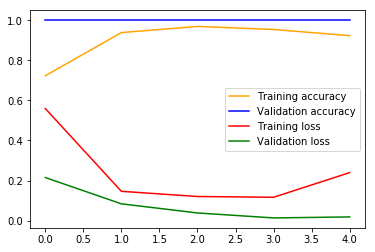

In [14]:
import matplotlib.pyplot as plt

print(history.history.keys())

plt.figure()
plt.plot(history.history['acc'], 'orange', label='Training accuracy')
plt.plot(history.history['val_acc'], 'blue', label='Validation accuracy')
plt.plot(history.history['loss'], 'red', label='Training loss')
plt.plot(history.history['val_loss'], 'green', label='Validation loss')
plt.legend()
plt.show()

### Create the Test dataset

In [15]:
test_dataset = p.get_dataset_by_name('TEST')
test_ann = test_dataset.get_annotations()
test_imgs_anns = test_dataset.associate_images_and_annotations(test_ann, label_ids)
test_image_ids = train_dataset.get_image_ids(test_ann)

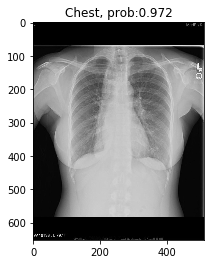

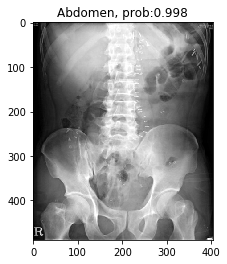

In [19]:
from skimage.transform import resize

for image_id in test_image_ids: 
    
    image = vis.load_dicom_image(image_id, to_RGB=True)
    plt.figure()
    plt.imshow(image)
    
    image = resize(image, (img_width, img_height,3))
    x = np.expand_dims(image, axis=0)
    y_prob = model.predict(x) 
    y_classes = y_prob.argmax(axis=-1)
    
    title = class_id_to_label(y_classes[0]) + ', prob:' + str(round(y_prob[0][y_classes[0]], 3))
    plt.title(title)
    
plt.show()